# Surrogate-based inverse design of bending-induced bistable metamaterials
_____________________
### Scientific Machine Learning Course, The University of Texas at Austin
#### Sibo Zhang
#### Department of Civil, Architectural, and Environmental Engineering, Cockrell School of Engineering

## Summary

Bistable structural units that can reversibly snap between two stable configurations are promising for applications in shape morphing and energy absorption. However, determining suitable unit-cell geometries for a prescribed target response remains challenging. 

In this work, we develop a **surrogate-based inverse design framework** for a **bending-induced bistable metamaterial unit**, built on a pre-established theoretical analytical model. 
- We first perform a parameter sweep in a dimensionless design space using the analytical model and extract eight scalar descriptors and a curve-type label from the normalized moment–rotation response.
- A **forward surrogate model** is then trained to map geometric parameters to these curve descriptors and curve type.
- Next, we compare two inverse strategies: a **direct inverse network** and **a cycle-consistent inverse network coupled with the forward model**.

The results show that both inverse models recover the geometric parameters with an average relative error of about 5–8% and generate moment–rotation curves that closely match the analytical model. The cycle-consistent inverse network achieves slightly higher accuracy in reproducing the target curves than the direct inverse model, demonstrating the feasibility of fast surrogate-based inverse design.

## 1. Forward surrogate model

### 1.1 Model

Curve-type label mapping: {0: 0, 1: 1, 2: 2}
Using device: cpu
Classifier trainable params: 17539
[Classifier] Epoch 0001/1000 | train_loss=0.5393, train_acc=0.7914, val_loss=0.4822, val_acc=0.8533
[Classifier] Epoch 0050/1000 | train_loss=0.0646, train_acc=0.9743, val_loss=0.0673, val_acc=0.9667
[Classifier] Epoch 0100/1000 | train_loss=0.0221, train_acc=0.9929, val_loss=0.0310, val_acc=0.9933
[Classifier] Epoch 0150/1000 | train_loss=0.0291, train_acc=0.9886, val_loss=0.0326, val_acc=0.9867
[Classifier] Epoch 0200/1000 | train_loss=0.0137, train_acc=0.9943, val_loss=0.0577, val_acc=0.9867
[Classifier] Epoch 0250/1000 | train_loss=0.0281, train_acc=0.9943, val_loss=0.0327, val_acc=0.9800
Early stopping classifier training at epoch 291
Regressor trainable params: 17864
[Regressor] Epoch 0001/1000 | train_loss=0.4994, val_loss=0.5059
[Regressor] Epoch 0050/1000 | train_loss=0.0609, val_loss=0.0351
[Regressor] Epoch 0100/1000 | train_loss=0.0665, val_loss=0.0288
[Regressor] Epoch 0150/10

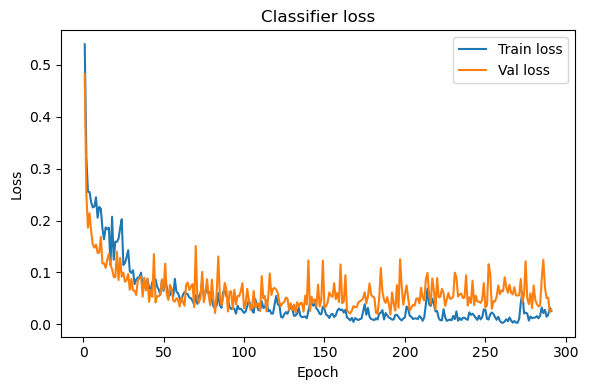

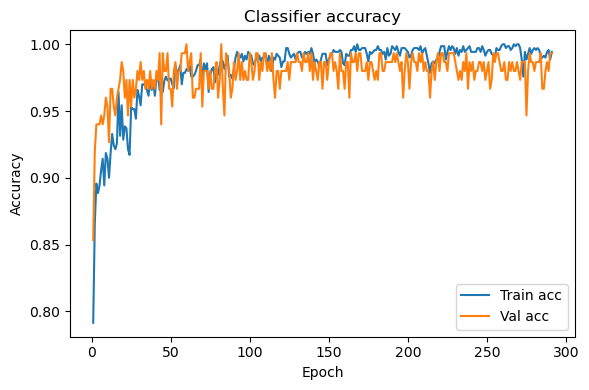

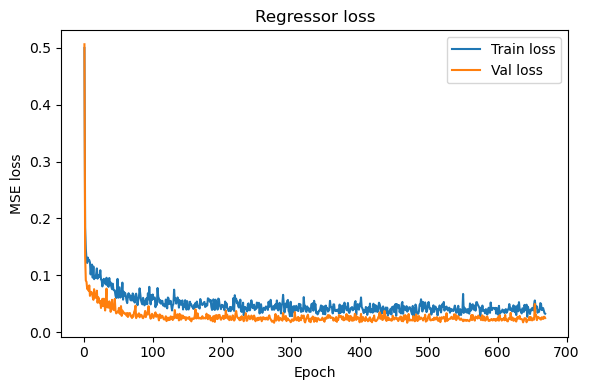

In [1]:
# ===== PyTorch forward surrogate =====

import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 0. Reproducibility: fix random seeds
# ---------------------------------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

GLOBAL_SEED = 42
set_seed(GLOBAL_SEED)

# ---------------------------------------------------
# 1. Load dataset from CSV
# ---------------------------------------------------

csv_path = "metrics_dimless__bend+tor+int.csv"  # change if needed
df = pd.read_csv(csv_path)

# Replace inf with NaN and drop invalid rows
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna().reset_index(drop=True)

# ---------------------------------------------------
# 2. Build input X and targets
# ---------------------------------------------------

# Input: 3 geometry ratios
X = df[["B/L", "t/L", "A/t"]].to_numpy(dtype=np.float32)

# Regression targets: 8 curve descriptors
y_reg = df[
    [
        "Mpeak",
        "θpeak",
        "Mvalley",
        "θvalley",
        "ratio",
        "stiff",
        "θend",
        "Mend",
    ]
].to_numpy(dtype=np.float32)

# Classification target: existing "curvetype" column
y_cls_raw = df["curvetype"].to_numpy(dtype=np.int64)

# Map labels to 0,1,2,...
unique_labels = sorted(np.unique(y_cls_raw))
label_map = {old: idx for idx, old in enumerate(unique_labels)}
y_cls = np.array([label_map[v] for v in y_cls_raw], dtype=np.int64)
num_classes = len(unique_labels)
print("Curve-type label mapping:", label_map)

# ---------------------------------------------------
# 3. Train/val/test split and scaling (70/15/15)
# ---------------------------------------------------

# First split: train (70%) and temp (30%)
X_train, X_temp, y_reg_train, y_reg_temp, y_cls_train, y_cls_temp = train_test_split(
    X, y_reg, y_cls,
    test_size=0.3,
    random_state=GLOBAL_SEED,
    shuffle=True,
)

# Second split: temp -> val (15%) and test (15%)
X_val, X_test, y_reg_val, y_reg_test, y_cls_val, y_cls_test = train_test_split(
    X_temp, y_reg_temp, y_cls_temp,
    test_size=0.5, 
    random_state=GLOBAL_SEED,
    shuffle=True,
)

# Standardize X and y_reg using only training data
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_val_scaled   = x_scaler.transform(X_val)
X_test_scaled  = x_scaler.transform(X_test)

y_reg_train_scaled = y_scaler.fit_transform(y_reg_train)
y_reg_val_scaled   = y_scaler.transform(y_reg_val)
y_reg_test_scaled  = y_scaler.transform(y_reg_test)

# ---------------------------------------------------
# 4. PyTorch Dataset
# ---------------------------------------------------

class BendingDataset(Dataset):
    def __init__(self, X, y_reg, y_cls):
        self.X = torch.from_numpy(X).float()
        self.y_reg = torch.from_numpy(y_reg).float()
        self.y_cls = torch.from_numpy(y_cls).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_reg[idx], self.y_cls[idx]

train_dataset = BendingDataset(X_train_scaled, y_reg_train_scaled, y_cls_train)
val_dataset   = BendingDataset(X_val_scaled,   y_reg_val_scaled,   y_cls_val)

# Generator for deterministic shuffling
g = torch.Generator()
g.manual_seed(GLOBAL_SEED)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, drop_last=False, generator=g
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False, drop_last=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------
# 5. Classifier: geometry -> curve type
# ---------------------------------------------------

class ForwardClassifier(nn.Module):
    def __init__(self, input_dim=3, num_classes=3, hidden_sizes=(64, 128, 64)):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            in_dim = h
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

clf_model = ForwardClassifier(
    input_dim=X_train_scaled.shape[1],
    num_classes=num_classes,
    hidden_sizes=(64, 128, 64),
).to(device)

clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = torch.optim.Adam(clf_model.parameters(), lr=1e-3)

def eval_classifier(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X_batch, _, y_cls_batch in data_loader:
            X_batch = X_batch.to(device)
            y_cls_batch = y_cls_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_cls_batch)

            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y_cls_batch).sum().item()
            total_samples += X_batch.size(0)
    avg_loss = total_loss / max(total_samples, 1)
    avg_acc = total_correct / max(total_samples, 1)
    return avg_loss, avg_acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Classifier trainable params:", count_parameters(clf_model))

best_val_loss = np.inf
patience = 100
patience_counter = 0
max_epochs = 1000

clf_train_loss_hist = []
clf_val_loss_hist = []
clf_train_acc_hist = []
clf_val_acc_hist = []

for epoch in range(1, max_epochs + 1):
    clf_model.train()
    train_loss = 0.0
    train_correct = 0
    train_samples = 0

    for X_batch, _, y_cls_batch in train_loader:
        X_batch = X_batch.to(device)
        y_cls_batch = y_cls_batch.to(device)

        clf_optimizer.zero_grad()
        logits = clf_model(X_batch)
        loss = clf_criterion(logits, y_cls_batch)
        loss.backward()
        clf_optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == y_cls_batch).sum().item()
        train_samples += X_batch.size(0)

    train_loss /= max(train_samples, 1)
    train_acc = train_correct / max(train_samples, 1)

    val_loss, val_acc = eval_classifier(
        clf_model, val_loader, clf_criterion, device
    )

    clf_train_loss_hist.append(train_loss)
    clf_val_loss_hist.append(val_loss)
    clf_train_acc_hist.append(train_acc)
    clf_val_acc_hist.append(val_acc)

    if (epoch == 1) or (epoch % 50 == 0):
        print(
            f"[Classifier] Epoch {epoch:04d}/{max_epochs} | "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
        )

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(clf_model.state_dict(), "forward_classifier_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping classifier training at epoch", epoch)
            break

clf_model.load_state_dict(torch.load("forward_classifier_best.pth"))

# ---------------------------------------------------
# 6. Regressor: geometry -> curve descriptors (8 outputs)
# ---------------------------------------------------

class ForwardRegressor(nn.Module):
    def __init__(self, input_dim=3, output_dim=8, hidden_sizes=(64, 128, 64)):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

reg_model = ForwardRegressor(
    input_dim=X_train_scaled.shape[1],
    output_dim=y_reg_train_scaled.shape[1],
    hidden_sizes=(64, 128, 64),
).to(device)

reg_criterion = nn.MSELoss()
reg_optimizer = torch.optim.Adam(reg_model.parameters(), lr=1e-3)

print("Regressor trainable params:", count_parameters(reg_model))

def eval_regressor(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for X_batch, y_reg_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_reg_batch = y_reg_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_reg_batch)
            total_loss += loss.item() * X_batch.size(0)
            total_samples += X_batch.size(0)
    avg_loss = total_loss / max(total_samples, 1)
    return avg_loss

best_val_loss = np.inf
patience = 200
patience_counter = 0
max_epochs = 1000

reg_train_loss_hist = []
reg_val_loss_hist = []

for epoch in range(1, max_epochs + 1):
    reg_model.train()
    train_loss = 0.0
    train_samples = 0

    for X_batch, y_reg_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_optimizer.zero_grad()
        preds = reg_model(X_batch)
        loss = reg_criterion(preds, y_reg_batch)
        loss.backward()
        reg_optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_samples += X_batch.size(0)

    train_loss /= max(train_samples, 1)
    val_loss = eval_regressor(reg_model, val_loader, reg_criterion, device)

    reg_train_loss_hist.append(train_loss)
    reg_val_loss_hist.append(val_loss)

    if (epoch == 1) or (epoch % 50 == 0):
        print(
            f"[Regressor] Epoch {epoch:04d}/{max_epochs} | "
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}"
        )

    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(reg_model.state_dict(), "forward_regressor_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping regressor training at epoch", epoch)
            break

reg_model.load_state_dict(torch.load("forward_regressor_best.pth"))

# ---------------------------------------------------
# 7. Plot training curves
# ---------------------------------------------------

epochs_clf = range(1, len(clf_train_loss_hist) + 1)
epochs_reg = range(1, len(reg_train_loss_hist) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_clf, clf_train_loss_hist, label="Train loss")
plt.plot(epochs_clf, clf_val_loss_hist, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classifier loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_clf, clf_train_acc_hist, label="Train acc")
plt.plot(epochs_clf, clf_val_acc_hist, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classifier accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_reg, reg_train_loss_hist, label="Train loss")
plt.plot(epochs_reg, reg_val_loss_hist, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Regressor loss")
plt.legend()
plt.tight_layout()
plt.show()


### 1.2 Evaluation and Visualization


=== Classifier evaluation on TEST set ===
Accuracy: 0.9933333333333333
Confusion matrix:
[[61  0  0]
 [ 1 28  0]
 [ 0  0 60]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.97      0.98        29
           2       1.00      1.00      1.00        60

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150


=== Regressor evaluation on TEST set ===
Mpeak      | MAE=4.2233e-03, RMSE=6.5940e-03, R2=0.997
theta_peak | MAE=1.8815e-02, RMSE=2.1848e-02, R2=0.995
Mvalley    | MAE=3.5345e-03, RMSE=5.3893e-03, R2=0.994
theta_valley | MAE=4.9966e-02, RMSE=8.3006e-02, R2=0.934
ratio      | MAE=3.4852e-02, RMSE=4.1132e-02, R2=0.994
stiff      | MAE=4.1151e-02, RMSE=6.4099e-02, R2=0.997
theta_end  | MAE=5.2730e-02, RMSE=6.8642e-02, R2=0.994
Mend       | MAE=3.0403e-03, RMSE=6.326

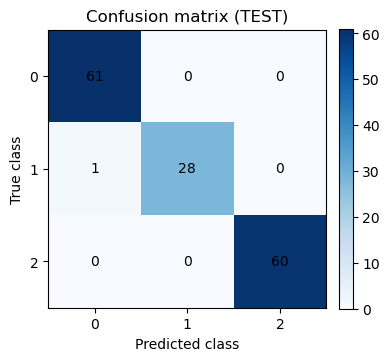

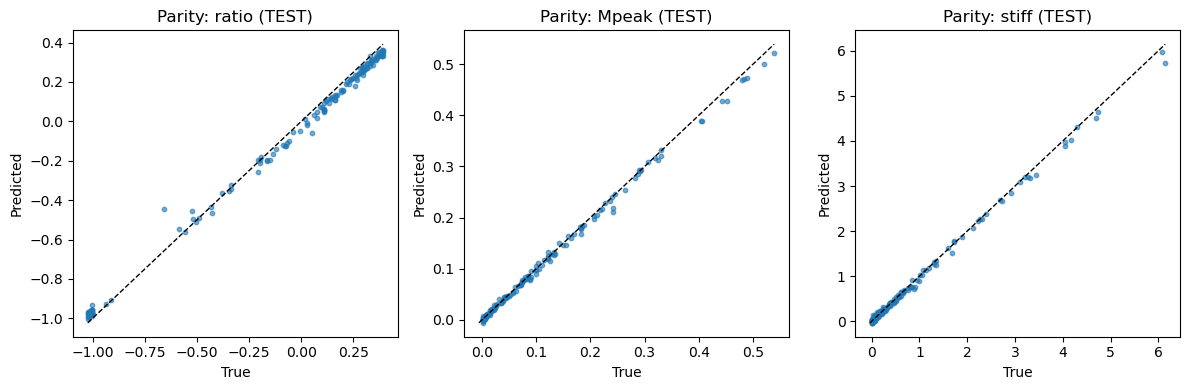

In [2]:
# ------------------------------------------------------------
# 8. Evaluation on TEST set
# ------------------------------------------------------------

# ---- 8.1 Classifier ----
clf_model.eval()
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test_scaled).float().to(device)
    logits_test = clf_model(X_test_t)
    preds_test = torch.argmax(logits_test, dim=1).cpu().numpy()

print("\n=== Classifier evaluation on TEST set ===")
print("Accuracy:", np.mean(preds_test == y_cls_test))

cm = confusion_matrix(y_cls_test, preds_test)
print("Confusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(y_cls_test, preds_test))

# ---- 8.2 Regressor ----
reg_model.eval()
with torch.no_grad():
    y_reg_test_pred_scaled = (
        reg_model(torch.from_numpy(X_test_scaled).float().to(device))
        .cpu()
        .numpy()
    )
y_reg_test_pred = y_scaler.inverse_transform(y_reg_test_pred_scaled)

print("\n=== Regressor evaluation on TEST set ===")
feature_names = [
    "Mpeak",
    "theta_peak",
    "Mvalley",
    "theta_valley",
    "ratio",
    "stiff",
    "theta_end",
    "Mend",
]

for i, name in enumerate(feature_names):
    y_true = y_reg_test[:, i]
    y_pred = y_reg_test_pred[:, i]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:10s} | MAE={mae:.4e}, RMSE={rmse:.4e}, R2={r2:.3f}")

# ------------------------------------------------------------
# 9. Visualization: confusion matrix & parity plots
# ------------------------------------------------------------

def plot_confusion_matrix(cm, class_labels=None, title="Confusion matrix (TEST)"):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")

    n_classes = cm.shape[0]
    if class_labels is None:
        class_labels = list(range(n_classes))

    ax.set_xticks(range(n_classes))
    ax.set_yticks(range(n_classes))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)

    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    ax.set_title(title)

    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(
                j,
                i,
                int(cm[i, j]),
                ha="center",
                va="center",
                color="black",
            )

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def parity_on_axis(ax, y_true, y_pred, title):
    ax.scatter(y_true, y_pred, s=10, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1.0)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(title)

# 9.1 Confusion matrix heatmap
plot_confusion_matrix(cm, class_labels=range(num_classes))

# 9.2 One-row parity plots: ratio, Mpeak, stiff
idx_Mpeak = feature_names.index("Mpeak")
idx_ratio = feature_names.index("ratio")
idx_stiff = feature_names.index("stiff")

y_true_Mpeak = y_reg_test[:, idx_Mpeak]
y_pred_Mpeak = y_reg_test_pred[:, idx_Mpeak]

y_true_ratio = y_reg_test[:, idx_ratio]
y_pred_ratio = y_reg_test_pred[:, idx_ratio]

y_true_stiff = y_reg_test[:, idx_stiff]
y_pred_stiff = y_reg_test_pred[:, idx_stiff]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

parity_on_axis(axes[0], y_true_ratio, y_pred_ratio, "Parity: ratio (TEST)")
parity_on_axis(axes[1], y_true_Mpeak, y_pred_Mpeak, "Parity: Mpeak (TEST)")
parity_on_axis(axes[2], y_true_stiff, y_pred_stiff, "Parity: stiff (TEST)")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Function: forward regressor prediction
# ------------------------------------------------------------

def predict_curve_features(bl, tl, qt):
    """
    Input:  B/L, t/L, A/t (floats)
    Output: unscaled curve features
            [Mpeak, θpeak, Mvalley, θvalley, ratio, stiff, θend, Mend]
    """
    reg_model.eval()
    x = np.array([[bl, tl, qt]], dtype=np.float32)
    x_scaled = x_scaler.transform(x)
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_scaled).float().to(device)
        y_pred_scaled = reg_model(x_tensor).cpu().numpy()
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    return y_pred[0]


## 2. Direct inverse design model

### 2.1 Model

Using device: cpu
[Inverse] Epoch 0001/1000 | train_loss=0.3097, val_loss=0.4533
[Inverse] Epoch 0050/1000 | train_loss=0.0633, val_loss=0.0344
[Inverse] Epoch 0100/1000 | train_loss=0.0702, val_loss=0.0541
[Inverse] Epoch 0150/1000 | train_loss=0.0662, val_loss=0.0273
[Inverse] Epoch 0200/1000 | train_loss=0.0605, val_loss=0.0318
[Inverse] Epoch 0250/1000 | train_loss=0.0599, val_loss=0.0347
[Inverse] Epoch 0300/1000 | train_loss=0.0479, val_loss=0.0389
[Inverse] Epoch 0350/1000 | train_loss=0.0617, val_loss=0.0298
[Inverse] Epoch 0400/1000 | train_loss=0.0492, val_loss=0.0272
Early stopping inverse training at epoch 446


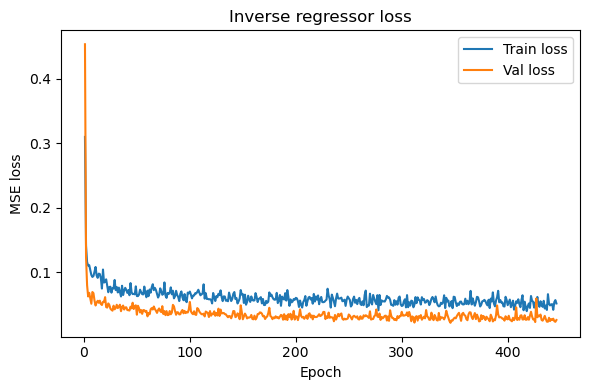

In [3]:
# ===== PyTorch inverse surrogate: curve features -> geometry (B/L, t/L, A/t) =====

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# 0. Reproducibility
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

GLOBAL_SEED_INV = 42
set_seed(GLOBAL_SEED_INV)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1. Load CSV and build X_inv_all, y_inv_all
# -----------------------------
csv_path = "metrics_dimless__bend+tor+int.csv"
df_inv = pd.read_csv(csv_path)
df_inv = df_inv.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# Input of inverse model: curve descriptors (8)
X_inv_all = df_inv[
    [
        "Mpeak",
        "θpeak",
        "Mvalley",
        "θvalley",
        "ratio",
        "stiff",
        "θend",
        "Mend",
    ]
].to_numpy(dtype=np.float32)

# Output of inverse model: geometry ratios (3)
y_inv_all = df_inv[["B/L", "t/L", "A/t"]].to_numpy(dtype=np.float32)

# -----------------------------
# 2. Train/val/test split + scaling (70/15/15)
# -----------------------------
# First split: train (70%) and temp (30%)
X_inv_train, X_inv_temp, y_inv_train, y_inv_temp = train_test_split(
    X_inv_all,
    y_inv_all,
    test_size=0.3,
    random_state=GLOBAL_SEED_INV,
    shuffle=True,
)

# Second split: temp -> val (15%) and test (15%)
X_inv_val, X_inv_test, y_inv_val, y_inv_test = train_test_split(
    X_inv_temp,
    y_inv_temp,
    test_size=0.5,
    random_state=GLOBAL_SEED_INV,
    shuffle=True,
)

x_scaler_inv = StandardScaler()
y_scaler_inv = StandardScaler()

X_inv_train_scaled = x_scaler_inv.fit_transform(X_inv_train)
X_inv_val_scaled   = x_scaler_inv.transform(X_inv_val)
X_inv_test_scaled  = x_scaler_inv.transform(X_inv_test)

y_inv_train_scaled = y_scaler_inv.fit_transform(y_inv_train)
y_inv_val_scaled   = y_scaler_inv.transform(y_inv_val)
y_inv_test_scaled  = y_scaler_inv.transform(y_inv_test)

# -----------------------------
# 3. Dataset
# -----------------------------
class InverseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset_inv = InverseDataset(X_inv_train_scaled, y_inv_train_scaled)
val_dataset_inv   = InverseDataset(X_inv_val_scaled,   y_inv_val_scaled)

g_inv = torch.Generator()
g_inv.manual_seed(GLOBAL_SEED_INV)

train_loader_inv = DataLoader(
    train_dataset_inv, batch_size=32, shuffle=True, drop_last=False, generator=g_inv
)
val_loader_inv = DataLoader(
    val_dataset_inv, batch_size=32, shuffle=False, drop_last=False
)

# -----------------------------
# 4. Inverse MLP model
# -----------------------------
class InverseRegressor(nn.Module):
    def __init__(self, input_dim=8, output_dim=3, hidden_sizes=(64, 128, 64)):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

inv_model = InverseRegressor(
    input_dim=X_inv_train_scaled.shape[1],
    output_dim=y_inv_train_scaled.shape[1],
    hidden_sizes=(64, 128, 64),
).to(device)

criterion_inv = nn.MSELoss()
optimizer_inv = torch.optim.Adam(inv_model.parameters(), lr=1e-3)

def eval_inverse(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            total_samples += X_batch.size(0)
    return total_loss / max(total_samples, 1)

# -----------------------------
# 5. Training loop
# -----------------------------
max_epochs_inv   = 1000
patience_inv     = 100
best_val_loss_inv   = np.inf
patience_counter_inv = 0

train_loss_hist_inv = []
val_loss_hist_inv   = []

for epoch in range(1, max_epochs_inv + 1):
    inv_model.train()
    train_loss = 0.0
    train_samples = 0

    for X_batch, y_batch in train_loader_inv:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer_inv.zero_grad()
        preds = inv_model(X_batch)
        loss = criterion_inv(preds, y_batch)
        loss.backward()
        optimizer_inv.step()

        train_loss += loss.item() * X_batch.size(0)
        train_samples += X_batch.size(0)

    train_loss /= max(train_samples, 1)
    val_loss = eval_inverse(inv_model, val_loader_inv, criterion_inv, device)

    train_loss_hist_inv.append(train_loss)
    val_loss_hist_inv.append(val_loss)

    if (epoch == 1) or (epoch % 50 == 0):
        print(
            f"[Inverse] Epoch {epoch:04d}/{max_epochs_inv} | "
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}"
        )

    if val_loss < best_val_loss_inv - 1e-5:
        best_val_loss_inv = val_loss
        patience_counter_inv = 0
        torch.save(inv_model.state_dict(), "inverse_regressor_best.pth")
    else:
        patience_counter_inv += 1
        if patience_counter_inv >= patience_inv:
            print("Early stopping inverse training at epoch", epoch)
            break

inv_model.load_state_dict(torch.load("inverse_regressor_best.pth"))

# -----------------------------
# 6. Plot training curves
# -----------------------------
epochs_inv = range(1, len(train_loss_hist_inv) + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs_inv, train_loss_hist_inv, label="Train loss")
plt.plot(epochs_inv, val_loss_hist_inv, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Inverse regressor loss")
plt.legend()
plt.tight_layout()
plt.show()


### 2.2 Evaluation and Visualization


=== Inverse regressor evaluation on TEST set ===
B/L        | MAE=1.5775e-02, RMSE=2.0954e-02, R2=0.995, MeanRel=4.85%
t/L        | MAE=3.4186e-04, RMSE=4.3294e-04, R2=0.996, MeanRel=2.86%
A/t        | MAE=4.3288e-01, RMSE=9.1378e-01, R2=0.901, MeanRel=6.20%


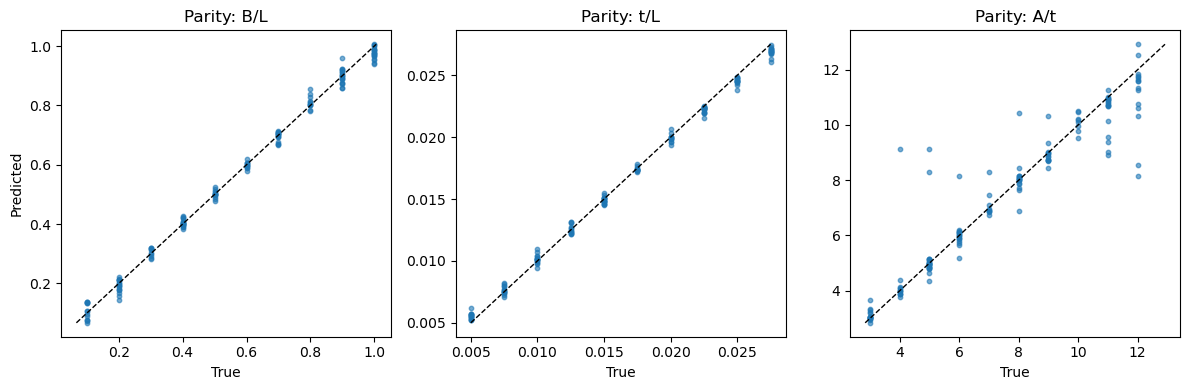

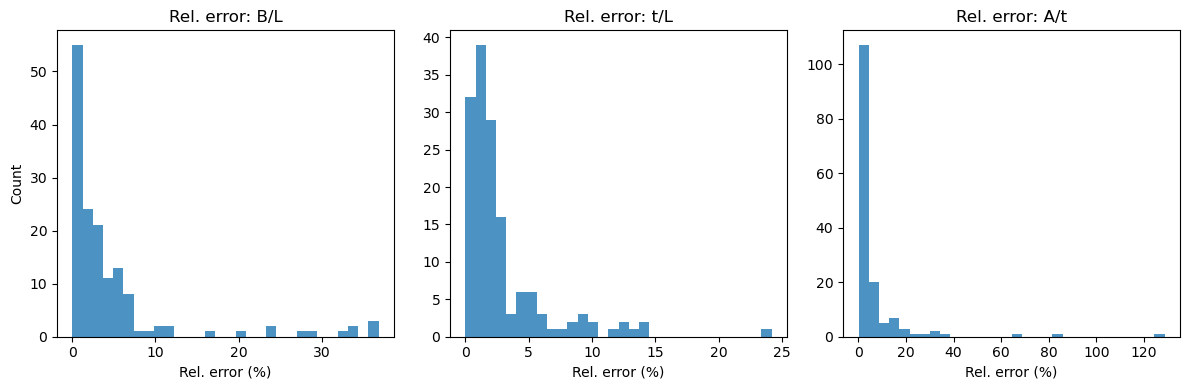

In [8]:
# ------------------------------------------------------------
# 7. Evaluation on TEST set
# ------------------------------------------------------------

inv_model.eval()
with torch.no_grad():
    X_inv_test_t = torch.from_numpy(X_inv_test_scaled).float().to(device)
    y_inv_test_pred_scaled = inv_model(X_inv_test_t).cpu().numpy()

# back to physical geometry space
y_inv_test_pred = y_scaler_inv.inverse_transform(y_inv_test_pred_scaled)

print("\n=== Inverse regressor evaluation on TEST set ===")
geom_names = ["B/L", "t/L", "A/t"]

for i, name in enumerate(geom_names):
    y_true = y_inv_test[:, i]
    y_pred = y_inv_test_pred[:, i]

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    abs_err = np.abs(y_pred - y_true)
    rel_err = abs_err / np.maximum(np.abs(y_true), 1e-8)
    mean_rel = np.mean(rel_err)

    print(
        f"{name:10s} | "
        f"MAE={mae:.4e}, RMSE={rmse:.4e}, R2={r2:.3f}, "
        f"MeanRel={mean_rel*100:.2f}%"
    )

# ------------------------------------------------------------
# 8. Visualization
# ------------------------------------------------------------

# 8.1 Parity plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(geom_names):
    ax = axes[i]
    y_true = y_inv_test[:, i]
    y_pred = y_inv_test_pred[:, i]

    ax.scatter(y_true, y_pred, s=10, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1.0)

    ax.set_xlabel("True")
    if i == 0:
        ax.set_ylabel("Predicted")
    ax.set_title(f"Parity: {name}")

fig.tight_layout()
plt.show()

# 8.2 Relative-error histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(geom_names):
    ax = axes[i]
    y_true = y_inv_test[:, i]
    y_pred = y_inv_test_pred[:, i]

    abs_err = np.abs(y_pred - y_true)
    rel_err = abs_err / np.maximum(np.abs(y_true), 1e-8)
    rel_pct = rel_err * 100.0

    ax.hist(rel_pct, bins=30, alpha=0.8)
    ax.set_xlabel("Rel. error (%)")
    if i == 0:
        ax.set_ylabel("Count")
    ax.set_title(f"Rel. error: {name}")

fig.tight_layout()
plt.show()

# ------------------------------------------------------------
# Function: descriptors -> geometry
# ------------------------------------------------------------

def predict_geometry_from_descriptors(
    Mpeak, theta_peak, Mvalley, theta_valley, ratio, stiff, theta_end, Mend
):
    inv_model.eval()
    x = np.array(
        [[Mpeak, theta_peak, Mvalley, theta_valley, ratio, stiff, theta_end, Mend]],
        dtype=np.float32,
    )
    x_scaled = x_scaler_inv.transform(x)
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_scaled).float().to(device)
        y_pred_scaled = inv_model(x_tensor).cpu().numpy()
    y_pred = y_scaler_inv.inverse_transform(y_pred_scaled)
    return y_pred[0]


## 3. Coupled inverse design model

### 3.1 Model

[Inverse-coupled] Epoch 0001/1000 | train_total=0.5321, val_total=0.6842, train_geom=0.4017, val_geom=0.4490, train_desc=0.3312, val_desc=0.4596
[Inverse-coupled] Epoch 0050/1000 | train_total=0.0671, val_total=0.0513, train_geom=0.0755, val_geom=0.0514, train_desc=0.0294, val_desc=0.0256
[Inverse-coupled] Epoch 0100/1000 | train_total=0.0640, val_total=0.0402, train_geom=0.0837, val_geom=0.0486, train_desc=0.0221, val_desc=0.0159
[Inverse-coupled] Epoch 0150/1000 | train_total=0.0615, val_total=0.0515, train_geom=0.0819, val_geom=0.0429, train_desc=0.0205, val_desc=0.0301
[Inverse-coupled] Epoch 0200/1000 | train_total=0.0632, val_total=0.0303, train_geom=0.0777, val_geom=0.0344, train_desc=0.0244, val_desc=0.0131
[Inverse-coupled] Epoch 0250/1000 | train_total=0.0698, val_total=0.0441, train_geom=0.0836, val_geom=0.0417, train_desc=0.0279, val_desc=0.0233
[Inverse-coupled] Epoch 0300/1000 | train_total=0.0542, val_total=0.0576, train_geom=0.0645, val_geom=0.0495, train_desc=0.0220, v

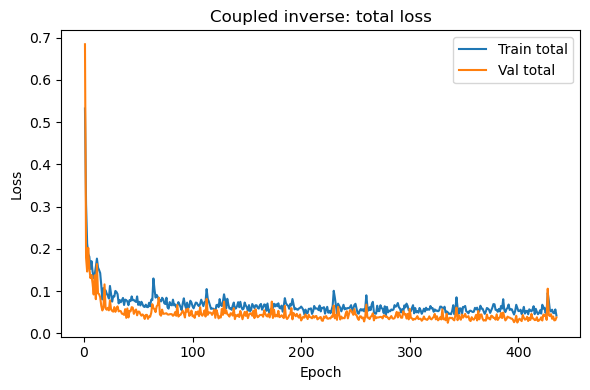

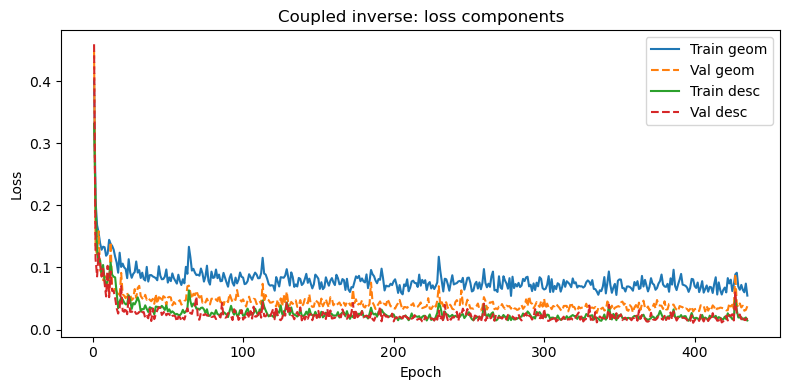

In [77]:
# ===== Coupled inverse surrogate: descriptors -> geometry (via forward surrogate) =====
# This script assumes that the following objects already exist from the forward script:
#   reg_model, clf_model, X_train_scaled, X_val_scaled, X_test,
#   y_reg_train_scaled, y_reg_val_scaled, y_reg_test_scaled,
#   y_reg_test, y_cls_train, y_cls_val, y_cls_test,
#   x_scaler, y_scaler, device, GLOBAL_SEED

import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

def set_seed_all(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# reuse GLOBAL_SEED from the forward script, or pick another fixed number
set_seed_all(GLOBAL_SEED)

# ------------------------------------------------------------
# 0. Freeze forward models
# ------------------------------------------------------------
reg_model.eval()
clf_model.eval()
for p in reg_model.parameters():
    p.requires_grad = False
for p in clf_model.parameters():
    p.requires_grad = False

# ------------------------------------------------------------
# 1. Dataset based on forward split (descriptors + curve type + geometry)
# ------------------------------------------------------------
class CoupledInverseDataset(Dataset):
    def __init__(self, desc_scaled, cls_labels, geom_scaled):
        """
        desc_scaled: (N, 8)  -> y_reg_train_scaled / y_reg_val_scaled
        cls_labels : (N,)    -> y_cls_train / y_cls_val
        geom_scaled: (N, 3)  -> X_train_scaled / X_val_scaled
        """
        self.desc = torch.from_numpy(desc_scaled).float()
        self.cls  = torch.from_numpy(cls_labels).long()
        self.geom = torch.from_numpy(geom_scaled).float()

    def __len__(self):
        return self.desc.shape[0]

    def __getitem__(self, idx):
        return self.desc[idx], self.cls[idx], self.geom[idx]

train_dataset_cpl = CoupledInverseDataset(
    y_reg_train_scaled,  # descriptors (scaled)
    y_cls_train,         # curve-type labels
    X_train_scaled,      # geometry (scaled)
)
val_dataset_cpl = CoupledInverseDataset(
    y_reg_val_scaled,
    y_cls_val,
    X_val_scaled,
)

g_cpl = torch.Generator()
g_cpl.manual_seed(GLOBAL_SEED)

train_loader_cpl = DataLoader(
    train_dataset_cpl,
    batch_size=32,
    shuffle=True,
    drop_last=False,
    generator=g_cpl,
)
val_loader_cpl = DataLoader(
    val_dataset_cpl,
    batch_size=32,
    shuffle=False,
    drop_last=False,
)

# ------------------------------------------------------------
# 2. Coupled inverse network: descriptors(8) -> geometry_scaled(3)
# ------------------------------------------------------------
class CoupledInverseNet(nn.Module):
    def __init__(self, input_dim=8, output_dim=3, hidden_sizes=(128, 256, 128)):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

inv_cpl_model = CoupledInverseNet(
    input_dim=y_reg_train_scaled.shape[1],  # 8
    output_dim=X_train_scaled.shape[1],     # 3
).to(device)

criterion_geom = nn.MSELoss()
criterion_desc = nn.MSELoss()

optimizer_cpl  = torch.optim.Adam(
    inv_cpl_model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
)

# weights for different loss terms
lambda_geom = 0.5   # geometry term
lambda_desc = 1.0   # descriptor term

def eval_inverse_coupled(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    geom_loss_sum = 0.0
    desc_loss_sum = 0.0
    total_samples = 0

    with torch.no_grad():
        for desc_batch, _, geom_batch in data_loader:
            desc_batch = desc_batch.to(device)
            geom_batch = geom_batch.to(device)

            # inverse: desc -> geom
            geom_pred_scaled = model(desc_batch)               # (B,3)

            # forward surrogate (frozen): geom -> desc
            desc_pred_scaled = reg_model(geom_pred_scaled)     # (B,8)

            # two components
            loss_geom = criterion_geom(geom_pred_scaled, geom_batch)
            loss_desc = criterion_desc(desc_pred_scaled, desc_batch)

            loss = lambda_geom * loss_geom + lambda_desc * loss_desc

            bs = desc_batch.size(0)
            total_loss    += loss.item()      * bs
            geom_loss_sum += loss_geom.item() * bs
            desc_loss_sum += loss_desc.item() * bs
            total_samples += bs

    if total_samples == 0:
        return 0.0, 0.0, 0.0

    avg_total = total_loss    / total_samples
    avg_geom  = geom_loss_sum / total_samples
    avg_desc  = desc_loss_sum / total_samples
    return avg_total, avg_geom, avg_desc

# ------------------------------------------------------------
# 3. Training loop
# ------------------------------------------------------------
max_epochs_cpl       = 1000
patience_cpl         = 100
best_val_loss_cpl    = np.inf
patience_counter_cpl = 0

train_total_hist_cpl = []
val_total_hist_cpl   = []

train_geom_hist_cpl  = []
val_geom_hist_cpl    = []

train_desc_hist_cpl  = []
val_desc_hist_cpl    = []

for epoch in range(1, max_epochs_cpl + 1):
    inv_cpl_model.train()
    train_total = 0.0
    train_geom  = 0.0
    train_desc  = 0.0
    train_samples = 0

    for desc_batch, _, geom_batch in train_loader_cpl:
        desc_batch = desc_batch.to(device)
        geom_batch = geom_batch.to(device)

        optimizer_cpl.zero_grad()

        # inverse: desc -> geom
        geom_pred_scaled = inv_cpl_model(desc_batch)

        # forward surrogate: geom -> desc
        desc_pred_scaled = reg_model(geom_pred_scaled)

        # two components
        loss_geom = criterion_geom(geom_pred_scaled, geom_batch)
        loss_desc = criterion_desc(desc_pred_scaled, desc_batch)

        loss = lambda_geom * loss_geom + lambda_desc * loss_desc

        loss.backward()
        optimizer_cpl.step()

        bs = desc_batch.size(0)
        train_total += loss.item()      * bs
        train_geom  += loss_geom.item() * bs
        train_desc  += loss_desc.item() * bs
        train_samples += bs

    # average over samples
    train_total /= max(train_samples, 1)
    train_geom  /= max(train_samples, 1)
    train_desc  /= max(train_samples, 1)

    val_total, val_geom, val_desc = eval_inverse_coupled(
        inv_cpl_model, val_loader_cpl, device
    )

    # record history
    train_total_hist_cpl.append(train_total)
    val_total_hist_cpl.append(val_total)

    train_geom_hist_cpl.append(train_geom)
    val_geom_hist_cpl.append(val_geom)

    train_desc_hist_cpl.append(train_desc)
    val_desc_hist_cpl.append(val_desc)

    if (epoch == 1) or (epoch % 50 == 0):
        print(
            f"[Inverse-coupled] Epoch {epoch:04d}/{max_epochs_cpl} | "
            f"train_total={train_total:.4f}, val_total={val_total:.4f}, "
            f"train_geom={train_geom:.4f}, val_geom={val_geom:.4f}, "
            f"train_desc={train_desc:.4f}, val_desc={val_desc:.4f}"
        )

    # early stopping based on total validation loss
    if val_total < best_val_loss_cpl - 1e-5:
        best_val_loss_cpl = val_total
        patience_counter_cpl = 0
        torch.save(inv_cpl_model.state_dict(), "inverse_coupled_best.pth")
    else:
        patience_counter_cpl += 1
        if patience_counter_cpl >= patience_cpl:
            print("Early stopping coupled inverse at epoch", epoch)
            break

inv_cpl_model.load_state_dict(torch.load("inverse_coupled_best.pth"))

# ------------------------------------------------------------
# 4. Plot training curves
# ------------------------------------------------------------
epochs_cpl = range(1, len(train_total_hist_cpl) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_cpl, train_total_hist_cpl, label="Train total")
plt.plot(epochs_cpl, val_total_hist_cpl,   label="Val total")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Coupled inverse: total loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs_cpl, train_geom_hist_cpl, label="Train geom")
plt.plot(epochs_cpl, val_geom_hist_cpl,   "--", label="Val geom")

plt.plot(epochs_cpl, train_desc_hist_cpl, label="Train desc")
plt.plot(epochs_cpl, val_desc_hist_cpl,   "--", label="Val desc")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Coupled inverse: loss components")
plt.legend()
plt.tight_layout()
plt.show()


### 3.2 Evaluation and Visualization


=== Coupled inverse: geometry error on TEST set ===
B/L   | MAE=1.7853e-02, RMSE=2.5758e-02, R2=0.993, MeanRel=5.73%
t/L   | MAE=3.5920e-04, RMSE=5.0878e-04, R2=0.995, MeanRel=3.42%
A/t   | MAE=5.3517e-01, RMSE=9.2207e-01, R2=0.899, MeanRel=8.91%


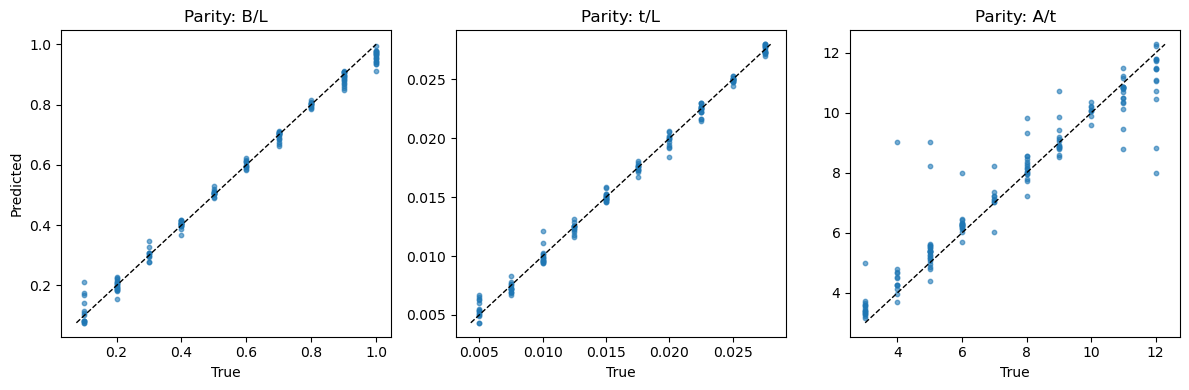

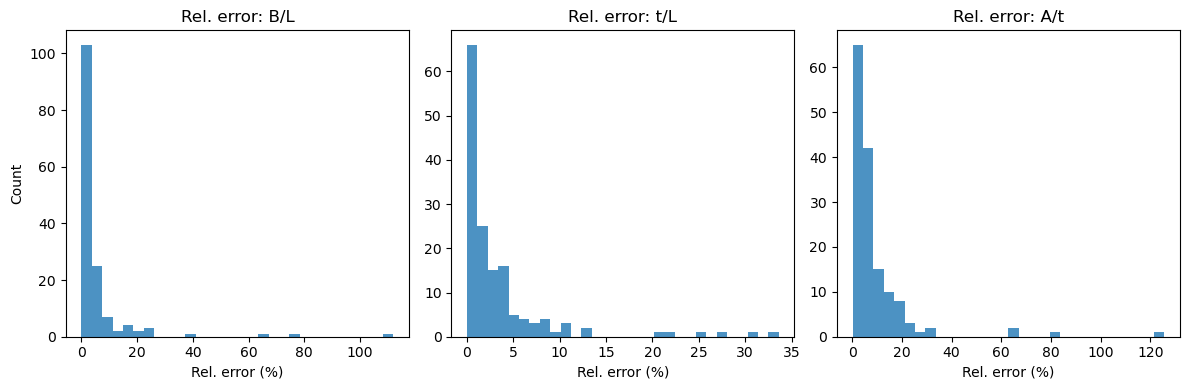

In [78]:
# ------------------------------------------------------------
# Evaluation of coupled inverse on TEST set (geometry only)
# ------------------------------------------------------------

inv_cpl_model.eval()
with torch.no_grad():
    # y_reg_test_scaled: descriptors on TEST set
    desc_test_scaled_t = torch.from_numpy(y_reg_test_scaled).float().to(device)

    geom_pred_scaled_t = inv_cpl_model(desc_test_scaled_t)
    geom_pred_scaled = geom_pred_scaled_t.cpu().numpy()

geom_pred = x_scaler.inverse_transform(geom_pred_scaled) 

# TEST 
geom_true = X_test  

print("\n=== Coupled inverse: geometry error on TEST set ===")
geom_names = ["B/L", "t/L", "A/t"]

for i, name in enumerate(geom_names):
    y_true = geom_true[:, i]
    y_pred = geom_pred[:, i]

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    abs_err = np.abs(y_pred - y_true)
    rel_err = abs_err / np.maximum(np.abs(y_true), 1e-8)
    mean_rel = np.mean(rel_err)

    print(
        f"{name:5s} | "
        f"MAE={mae:.4e}, RMSE={rmse:.4e}, R2={r2:.3f}, "
        f"MeanRel={mean_rel*100:.2f}%"
    )

# ------------------------------------------------------------
#  Parity plots for geometry (coupled inverse)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(geom_names):
    ax = axes[i]
    y_true = geom_true[:, i]
    y_pred = geom_pred[:, i]

    ax.scatter(y_true, y_pred, s=10, alpha=0.6)
    vmin = min(y_true.min(), y_pred.min())
    vmax = max(y_true.max(), y_pred.max())
    ax.plot([vmin, vmax], [vmin, vmax], "k--", linewidth=1.0)

    ax.set_xlabel("True")
    if i == 0:
        ax.set_ylabel("Predicted")
    ax.set_title(f"Parity: {name}")

fig.tight_layout()
plt.show()

# ------------------------------------------------------------
#  Relative-error histograms for geometry
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(geom_names):
    ax = axes[i]
    y_true = geom_true[:, i]
    y_pred = geom_pred[:, i]

    abs_err = np.abs(y_pred - y_true)
    rel_err = abs_err / np.maximum(np.abs(y_true), 1e-8)
    rel_pct = rel_err * 100.0

    ax.hist(rel_pct, bins=30, alpha=0.8)
    ax.set_xlabel("Rel. error (%)")
    if i == 0:
        ax.set_ylabel("Count")
    ax.set_title(f"Rel. error: {name}")

fig.tight_layout()
plt.show()

# ------------------------------------------------------------
# Function: descriptors -> geometry (coupled inverse)
# ------------------------------------------------------------

def predict_geometry_from_descriptors_coupled(
    Mpeak, theta_peak, Mvalley, theta_valley, ratio, stiff, theta_end, Mend
):
    """
    Input:  (Mpeak, theta_peak, Mvalley, theta_valley,
             ratio, stiff, theta_end, Mend)
    Output: [B/L, t/L, A/t]
    """
    inv_cpl_model.eval()

    desc = np.array(
        [[Mpeak, theta_peak, Mvalley, theta_valley,
          ratio, stiff, theta_end, Mend]],
        dtype=np.float32,
    )
    desc_scaled = y_scaler.transform(desc)

    with torch.no_grad():
        desc_t = torch.from_numpy(desc_scaled).float().to(device)
        geom_scaled = inv_cpl_model(desc_t).cpu().numpy()

    geom = x_scaler.inverse_transform(geom_scaled)
    return geom[0]


## 4. Results

### 4.1 Model round-trip check


=== Roundtrip-3 (DIRECT inverse): descriptors ===
Mpeak      | MAE=8.8090e-03, RMSE=1.4427e-02, R2=0.987, MeanRel=26.57%
theta_peak | MAE=2.0044e-02, RMSE=2.3552e-02, R2=0.994, MeanRel=7.23%
Mvalley    | MAE=5.7263e-03, RMSE=8.6619e-03, R2=0.985, MeanRel=93.69%
theta_valley | MAE=4.8628e-02, RMSE=7.7722e-02, R2=0.942, MeanRel=3.12%
ratio      | MAE=3.7824e-02, RMSE=4.5169e-02, R2=0.992, MeanRel=21.57%
stiff      | MAE=8.4818e-02, RMSE=1.5435e-01, R2=0.985, MeanRel=50.11%
theta_end  | MAE=6.4236e-02, RMSE=9.2173e-02, R2=0.989, MeanRel=11.58%
Mend       | MAE=5.9069e-03, RMSE=1.1014e-02, R2=0.982, MeanRel=31.96%

=== Roundtrip-3 (DIRECT inverse): curve type ===
Accuracy: 0.9933333333333333
Confusion matrix:
 [[61  0  0]
 [ 1 28  0]
 [ 0  0 60]]


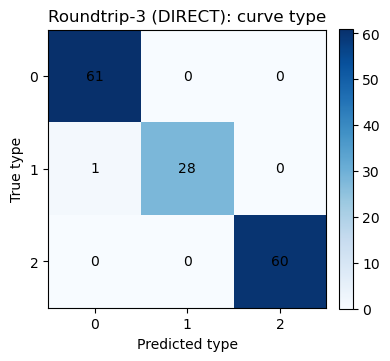

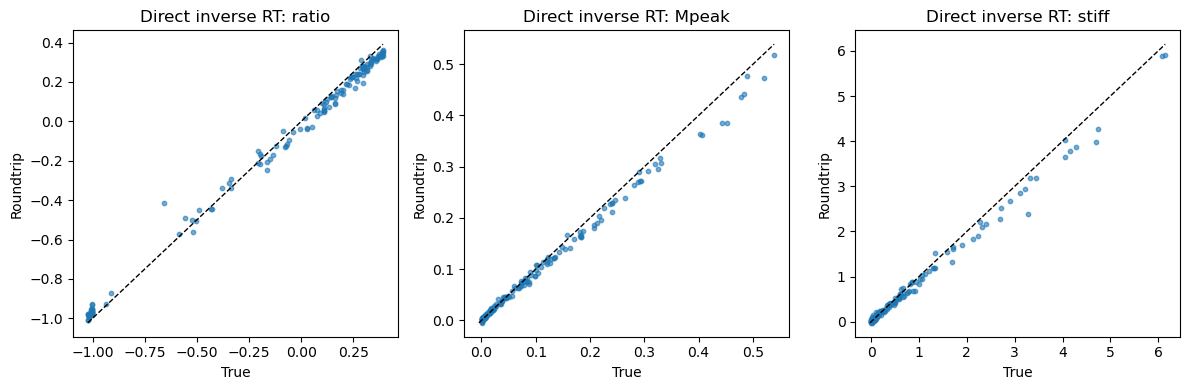


=== Roundtrip-3 (COUPLED inverse): descriptors ===
Mpeak      | MAE=4.5073e-03, RMSE=6.8717e-03, R2=0.997, MeanRel=18.84%
theta_peak | MAE=2.1218e-02, RMSE=2.5570e-02, R2=0.993, MeanRel=6.85%
Mvalley    | MAE=3.3168e-03, RMSE=5.2349e-03, R2=0.995, MeanRel=77.98%
theta_valley | MAE=3.6035e-02, RMSE=5.5609e-02, R2=0.970, MeanRel=2.32%
ratio      | MAE=3.4789e-02, RMSE=4.3328e-02, R2=0.993, MeanRel=15.18%
stiff      | MAE=4.5951e-02, RMSE=7.4228e-02, R2=0.996, MeanRel=59.93%
theta_end  | MAE=7.8119e-02, RMSE=1.0615e-01, R2=0.986, MeanRel=14.41%
Mend       | MAE=3.9536e-03, RMSE=6.9863e-03, R2=0.993, MeanRel=24.58%

=== Roundtrip-3 (COUPLED inverse): curve type ===
Accuracy: 0.9733333333333334
Confusion matrix:
 [[60  1  0]
 [ 1 26  2]
 [ 0  0 60]]


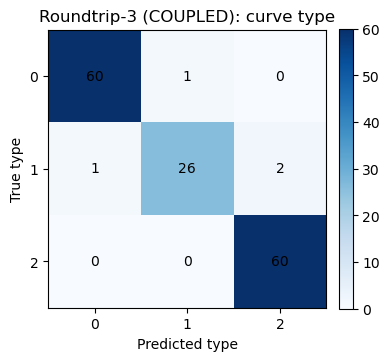

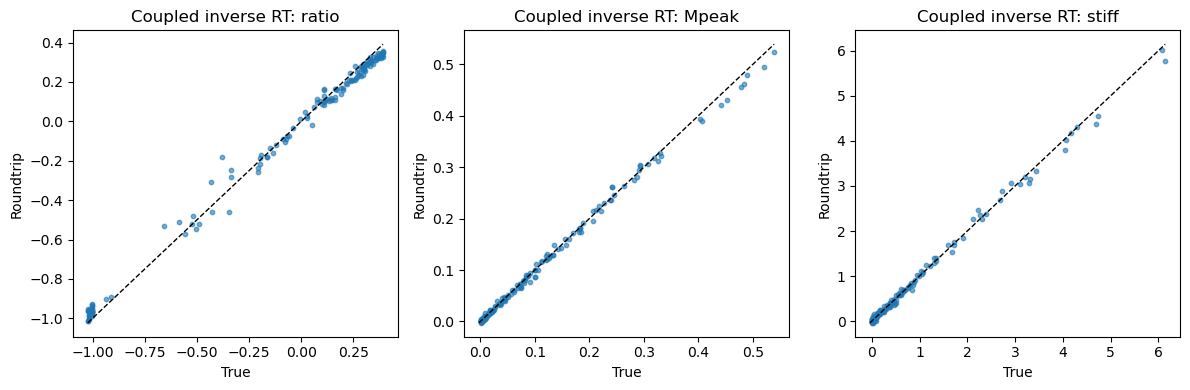

In [79]:
from sklearn.metrics import r2_score, confusion_matrix

# ------------------------------------------------------------
# Common names & small helper
# ------------------------------------------------------------
feature_names = [
    "Mpeak",
    "theta_peak",
    "Mvalley",
    "theta_valley",
    "ratio",
    "stiff",
    "theta_end",
    "Mend",
]
geom_names = ["B/L", "t/L", "A/t"]

key_feats_to_plot = ["ratio", "Mpeak", "stiff"]
key_idx = [feature_names.index(n) for n in key_feats_to_plot]

def parity_on_axis(ax, y_true, y_pred, title):
    ax.scatter(y_true, y_pred, s=10, alpha=0.6)
    vmin = min(y_true.min(), y_pred.min())
    vmax = max(y_true.max(), y_pred.max())
    ax.plot([vmin, vmax], [vmin, vmax], "k--", linewidth=1.0)
    ax.set_xlabel("True")
    ax.set_ylabel("Roundtrip")
    ax.set_title(title)

def plot_confusion(cm, class_labels, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(class_labels)))
    ax.set_yticks(range(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    ax.set_xlabel("Predicted type")
    ax.set_ylabel("True type")
    ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),
                    ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


# ============================================================================
# Roundtrip-3 (A) : DIRECT INVERSE + FORWARD SURROGATE
#   descriptor_true -> direct inverse -> geom_pred
#                   -> forward (reg+clf) -> descriptor_rt, type_rt
#   Compare descriptor_rt vs descriptor_true, type_rt vs type_true
# ============================================================================

inv_model.eval()
reg_model.eval()
clf_model.eval()

desc_true = y_reg_test          # (N, 8), unscaled
cls_true  = y_cls_test          # (N,)

# 1) descriptor_true -> direct inverse -> geometry_pred (unscaled)
desc_scaled_for_inv = x_scaler_inv.transform(desc_true)

with torch.no_grad():
    desc_t = torch.from_numpy(desc_scaled_for_inv).float().to(device)
    geom_pred_scaled_direct = inv_model(desc_t).cpu().numpy()

geom_pred_direct = y_scaler_inv.inverse_transform(geom_pred_scaled_direct)  # (N, 3)

# 2) geometry_pred -> forward reg+clf -> descriptor_roundtrip, type_roundtrip
geom_pred_scaled_for_fwd = x_scaler.transform(geom_pred_direct)

with torch.no_grad():
    geom_t = torch.from_numpy(geom_pred_scaled_for_fwd).float().to(device)
    desc_rt_scaled_direct_t = reg_model(geom_t)
    logits_type_direct_t    = clf_model(geom_t)

desc_rt_scaled_direct = desc_rt_scaled_direct_t.cpu().numpy()
logits_type_direct    = logits_type_direct_t.cpu().numpy()

desc_rt_direct = y_scaler.inverse_transform(desc_rt_scaled_direct)   # (N, 8)
cls_rt_direct  = np.argmax(logits_type_direct, axis=1)

# 3) Descriptor roundtrip metrics
print("\n=== Roundtrip-3 (DIRECT inverse): descriptors ===")
for i, name in enumerate(feature_names):
    y_true = desc_true[:, i]
    y_pred = desc_rt_direct[:, i]

    abs_err = np.abs(y_pred - y_true)
    rel_err = abs_err / np.maximum(np.abs(y_true), 1e-8)

    mae   = np.mean(abs_err)
    rmse  = np.sqrt(np.mean(abs_err**2))
    r2    = r2_score(y_true, y_pred)
    mean_rel = np.mean(rel_err)

    print(
        f"{name:10s} | "
        f"MAE={mae:.4e}, RMSE={rmse:.4e}, R2={r2:.3f}, "
        f"MeanRel={mean_rel*100:.2f}%"
    )

# 4) Curve-type roundtrip metrics
cm_direct = confusion_matrix(cls_true, cls_rt_direct)
acc_type_direct = np.mean(cls_rt_direct == cls_true)

print("\n=== Roundtrip-3 (DIRECT inverse): curve type ===")
print("Accuracy:", acc_type_direct)
print("Confusion matrix:\n", cm_direct)

plot_confusion(cm_direct, class_labels=range(num_classes),
               title="Roundtrip-3 (DIRECT): curve type")

# 5) Parity plots for a few key descriptors
fig, axes = plt.subplots(1, len(key_idx), figsize=(4 * len(key_idx), 4))
if len(key_idx) == 1:
    axes = [axes]

for ax, idx in zip(axes, key_idx):
    name = feature_names[idx]
    parity_on_axis(
        ax,
        desc_true[:, idx],
        desc_rt_direct[:, idx],
        title=f"Direct inverse RT: {name}",
    )
plt.tight_layout()
plt.show()


# ============================================================================
# Roundtrip-3 (B) : COUPLED INVERSE + FORWARD SURROGATE
#   descriptor_true -> coupled inverse -> geom_pred
#                   -> forward (reg+clf) -> descriptor_rt, type_rt
# ============================================================================

inv_cpl_model.eval()
reg_model.eval()
clf_model.eval()

desc_true = y_reg_test          # (N, 8), unscaled
cls_true  = y_cls_test          # (N,)

desc_test_scaled_for_cpl = y_reg_test_scaled   # (N, 8)

with torch.no_grad():
    desc_t = torch.from_numpy(desc_test_scaled_for_cpl).float().to(device)
    geom_pred_scaled_cpl = inv_cpl_model(desc_t)
    desc_rt_scaled_cpl_t = reg_model(geom_pred_scaled_cpl)
    logits_type_cpl_t    = clf_model(geom_pred_scaled_cpl)

geom_pred_scaled_cpl = geom_pred_scaled_cpl.cpu().numpy()
desc_rt_scaled_cpl   = desc_rt_scaled_cpl_t.cpu().numpy()
logits_type_cpl      = logits_type_cpl_t.cpu().numpy()

geom_pred_cpl = x_scaler.inverse_transform(geom_pred_scaled_cpl)    # (N, 3)
desc_rt_cpl   = y_scaler.inverse_transform(desc_rt_scaled_cpl)      # (N, 8)
cls_rt_cpl    = np.argmax(logits_type_cpl, axis=1)

# 1) Descriptor roundtrip metrics
print("\n=== Roundtrip-3 (COUPLED inverse): descriptors ===")
for i, name in enumerate(feature_names):
    y_true = desc_true[:, i]
    y_pred = desc_rt_cpl[:, i]

    abs_err = np.abs(y_pred - y_true)
    rel_err = abs_err / np.maximum(np.abs(y_true), 1e-8)

    mae   = np.mean(abs_err)
    rmse  = np.sqrt(np.mean(abs_err**2))
    r2    = r2_score(y_true, y_pred)
    mean_rel = np.mean(rel_err)

    print(
        f"{name:10s} | "
        f"MAE={mae:.4e}, RMSE={rmse:.4e}, R2={r2:.3f}, "
        f"MeanRel={mean_rel*100:.2f}%"
    )

# 2) Curve-type roundtrip metrics
cm_cpl = confusion_matrix(cls_true, cls_rt_cpl)
acc_type_cpl = np.mean(cls_rt_cpl == cls_true)

print("\n=== Roundtrip-3 (COUPLED inverse): curve type ===")
print("Accuracy:", acc_type_cpl)
print("Confusion matrix:\n", cm_cpl)

plot_confusion(cm_cpl, class_labels=range(num_classes),
               title="Roundtrip-3 (COUPLED): curve type")

# 3) Parity plots for key descriptors
fig, axes = plt.subplots(1, len(key_idx), figsize=(4 * len(key_idx), 4))
if len(key_idx) == 1:
    axes = [axes]

for ax, idx in zip(axes, key_idx):
    name = feature_names[idx]
    parity_on_axis(
        ax,
        desc_true[:, idx],
        desc_rt_cpl[:, idx],
        title=f"Coupled inverse RT: {name}",
    )
plt.tight_layout()
plt.show()


### 4.2 Case studies


=== Physical case (DIRECT inverse) ===
Predicted geometry (dimensionless):
  B/L = 0.7158
  t/L = 0.01499
  A/t = 8.925

Physical dimensions:
  L = 40.0 mm
  B = 28.630 mm
  t = 0.600 mm
  A = 5.352 mm

Target vs physics-based descriptors:
Mpeak        | target = +0.0600,  physics = +0.0633,  abs_err = +3.2851e-03,  rel_err =  5.48%
theta_peak   | target = +0.1800,  physics = +0.1809,  abs_err = +9.0452e-04,  rel_err =  0.50%
Mvalley      | target = -0.0200,  physics = -0.0191,  abs_err = +9.0944e-04,  rel_err = -4.55%
theta_valley | target = +1.8500,  physics = +1.8693,  abs_err = +1.9347e-02,  rel_err =  1.05%
ratio        | target = +0.3000,  physics = +0.3017,  abs_err = +1.6595e-03,  rel_err =  0.55%
stiff        | target = +0.5700,  physics = +0.5813,  abs_err = +1.1319e-02,  rel_err =  1.99%
theta_end    | target = +0.8000,  physics = +0.7832,  abs_err = -1.6754e-02,  rel_err = -2.09%
Mend         | target = +0.0200,  physics = +0.0216,  abs_err = +1.5746e-03,  rel_err =  7.87%

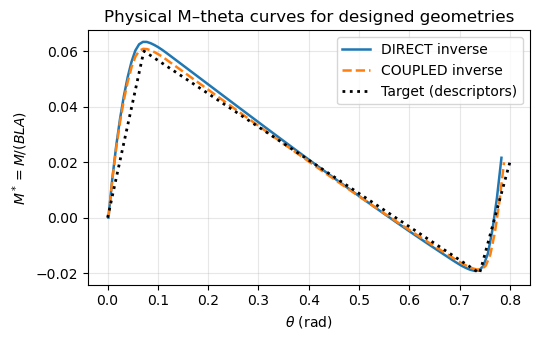

In [80]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Manual target descriptors (unscaled)
manual_target = np.array([
    0.06,   # Mpeak (normalized)
    0.18,   # theta_peak* (0–2)
    -0.02,  # Mvalley (normalized)
    1.85,   # theta_valley* (0–2)
    0.30,   # ratio
    0.57,   # stiff
    0.80,   # theta_end (physical theta_max, rad)
    0.02,   # Mend (normalized)
], dtype=np.float32)

descriptor_names = [
    "Mpeak", "theta_peak", "Mvalley", "theta_valley",
    "ratio", "stiff", "theta_end", "Mend",
]


def run_physical_inverse_case(
    target_desc,
    inverse_mode="direct",
    case_name="Physical inverse case"
):
    """
    inverse_mode: "direct" or "coupled"
      - "direct": use inv_model + (x_scaler_inv, y_scaler_inv)
      - "coupled": use inv_cpl_model + (y_scaler, x_scaler)
    """
    assert target_desc.shape == (8,)

    # ----- step 1: inverse model (descriptors -> geometry) -----
    if inverse_mode.lower() == "direct":
        inv_model.eval()
        with torch.no_grad():
            desc_scaled = x_scaler_inv.transform(target_desc.reshape(1, -1))
            desc_tensor = torch.from_numpy(desc_scaled).float().to(device)
            geom_pred_scaled = inv_model(desc_tensor).cpu().numpy()
            geom_dimless = y_scaler_inv.inverse_transform(geom_pred_scaled)[0]
    elif inverse_mode.lower() == "coupled":
        inv_cpl_model.eval()
        with torch.no_grad():
            desc_scaled = y_scaler.transform(target_desc.reshape(1, -1))
            desc_tensor = torch.from_numpy(desc_scaled).float().to(device)
            geom_pred_scaled = inv_cpl_model(desc_tensor).cpu().numpy()
            geom_dimless = x_scaler.inverse_transform(geom_pred_scaled)[0]
    else:
        raise ValueError(f"Unknown inverse_mode: {inverse_mode}")

    B_over_L, t_over_L, A_over_t = geom_dimless

    # ----- step 2: convert to physical dimensions -----
    E = 2000.0
    L = 40.0
    n = 4

    B = B_over_L * L
    t = t_over_L * L
    A = A_over_t * t

    if A >= B:
        A = 0.999 * B

    # ----- step 3: physical solver (bend + torsion + interaction) -----
    COMMON = dict(
        rep_mode="outer", arm_positive=True, kk=0.5,
        nf_range=(0.001, 12.05, 0.01),
        F_range=(-3000, 3000),
        scan_pts=1200,
        targets=(-100, 500),
        delta_clip=(0.0, 2.0),
        unify_points=100,
        verbose=False,
    )

    core = get_bending_core(
        E=E, L=L, b=B, h=A, t=t, n=n, **COMMON
    )

    sys_df = assemble_modes_from_core(
        core,
        include_torsion=True,
        include_interaction=True,
        nu_tor=0.30,
        nu_int=0.30,
    )

    # ----- step 4: extract descriptors from physical curve -----
    metrics = extract_metrics(
        sys_df,
        b=B, L=L, A=A,
        use_total=True,
        n_points=200,
        alpha_peak=0.3,
        ignore_endpoints=True,
    )

    desc_phys = np.array([
        metrics["peak_M"],
        metrics["peak_theta"],
        metrics["valley_M"],
        metrics["valley_theta"],
        metrics["bistable_ratio"],
        metrics["initial_stiffness"],
        metrics["theta_max"],
        metrics["M_at_theta_max"],
    ], dtype=np.float32)

    # ----- step 5: print comparison -----
    print(f"\n=== {case_name} ({inverse_mode.upper()} inverse) ===")
    print("Predicted geometry (dimensionless):")
    print(f"  B/L = {B_over_L:.4f}")
    print(f"  t/L = {t_over_L:.5f}")
    print(f"  A/t = {A_over_t:.3f}")

    print("\nPhysical dimensions:")
    print(f"  L = {L:.1f} mm")
    print(f"  B = {B:.3f} mm")
    print(f"  t = {t:.3f} mm")
    print(f"  A = {A:.3f} mm")

    print("\nTarget vs physics-based descriptors:")
    for i, name in enumerate(descriptor_names):
        tgt = float(target_desc[i])
        phy = float(desc_phys[i])
        abs_err = phy - tgt
        if abs(tgt) > 1e-8:
            rel_err = abs_err / tgt
            rel_pct = rel_err * 100.0
        else:
            rel_pct = np.nan
        print(
            f"{name:12s} | "
            f"target = {tgt:+.4f},  physics = {phy:+.4f},  "
            f"abs_err = {abs_err:+.4e},  rel_err = {rel_pct: .2f}%"
        )

    print(f"\nCurve type from physics model: {metrics['curve_type']}")
    return geom_dimless, desc_phys, metrics, sys_df, (B, L, A)


# ----- run both DIRECT and COUPLED inverse physical cases -----
geom_direct, desc_phys_direct, metrics_direct, sys_df_direct, (B_d, L_d, A_d) = \
    run_physical_inverse_case(
        manual_target,
        inverse_mode="direct",
        case_name="Physical case"
    )

geom_cpl, desc_phys_cpl, metrics_cpl, sys_df_cpl, (B_c, L_c, A_c) = \
    run_physical_inverse_case(
        manual_target,
        inverse_mode="coupled",
        case_name="Physical case"
    )

# ----- physical M–theta curves for two designs -----
theta_d = sys_df_direct["theta"].values.astype(float)
M_tot_d = sys_df_direct["M_total"].values.astype(float) / (B_d * L_d * A_d)

theta_c = sys_df_cpl["theta"].values.astype(float)
M_tot_c = sys_df_cpl["M_total"].values.astype(float) / (B_c * L_c * A_c)

# ----- build target curve from manual_target -----
Mp, thp_star, Mv, thv_star, ratio, stiff, theta_end_phys, Mend = manual_target

theta_peak_phys = 0.5 * thp_star * theta_end_phys
theta_valley_phys = 0.5 * thv_star * theta_end_phys

theta_target_knots = np.array(
    [0.0, theta_peak_phys, theta_valley_phys, theta_end_phys],
    dtype=float
)
M_star_target_knots = np.array(
    [0.0, Mp, Mv, Mend],
    dtype=float
)

theta_target = np.linspace(0.0, theta_end_phys, 200)
M_star_target = np.interp(theta_target, theta_target_knots, M_star_target_knots)

# ----- final plot: DIRECT, COUPLED, and TARGET -----
plt.figure(figsize=(5.5, 3.5))
plt.plot(theta_d, M_tot_d, label="DIRECT inverse", linewidth=1.8)
plt.plot(theta_c, M_tot_c, "--", label="COUPLED inverse", linewidth=1.8)
plt.plot(theta_target, M_star_target, "k:", linewidth=2.0, label="Target (descriptors)")

plt.xlabel(r"$\theta$ (rad)")
plt.ylabel(r"$M^* = M / (BLA)$")
plt.title("Physical M–theta curves for designed geometries")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### End